In [1]:
import os
import glob
import copy
import time
import json
import numpy as np 

import timm
from timm.data import resolve_model_data_config
from timm.data.transforms_factory import create_transform

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import matplotlib.pylab as plt

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import configs
import utils
import model_loader
import dataset

import warnings
warnings.filterwarnings("ignore") # Suppress all warnings

import torchattacks

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

/home/pfeng2/anaconda3/envs/hmn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
imagenet_label_info_path = configs.IN_LABEL_INFO
with open(imagenet_label_info_path, 'r') as file:
    imagenet_id2class = json.load(file)

superclass2imagenet_mapper, imagenet2superclass_mapper, _ = utils.superclass_label_mapping(
    imagenet_id2class, configs.IMAGNET_BINARY_RANGES, need_other=False)

print(imagenet_id2class['0'])
# print(superclass2imagenet_mapper[0])


['n01440764', 'tench']


In [3]:
BIG12_paths = [] 
BIG12_paths = glob.glob(os.path.join(configs.BIG12_DIR, '*.pth'))
print(len(BIG12_paths))

240


In [4]:
model_name = 'resnet18.tv_in1k'
ori_model, transform_train, transform_eval, data_config = model_loader.load_timm_model(
    model_name, pretrained=configs.NEED_PRETRAINED, num_classes=configs.NUM_CLASSES, device=device)

print(next(ori_model.parameters()).device)

wrapped_model = model_loader.CustomModelWrapper(ori_model, data_config, superclass2imagenet_mapper)
wrapped_model.eval()
wrapped_model = wrapped_model.to(device)

dummy_x = torch.rand(2, 3, 224, 224).to(device)
dummy_y = wrapped_model(dummy_x)
print(dummy_y.shape)

cuda:0
torch.Size([2, 2])


L2FMNAttack(steps=1000, max_stepsize=1, init_attack=None, min_stepsize=1e-05, binary_search_steps=10, gamma=10, p=2, dual=2)
0 animate  |  0 animate  |  1 in-animate  |  True  |  1.4807332754135132
0 animate  |  0 animate  |  1 in-animate  |  True  |  1.4977434873580933
1 in-animate  |  1 in-animate  |  0 animate  |  True  |  1.772334337234497
0 animate  |  0 animate  |  1 in-animate  |  True  |  0.9997796416282654
0 animate  |  0 animate  |  1 in-animate  |  True  |  1.5400885343551636


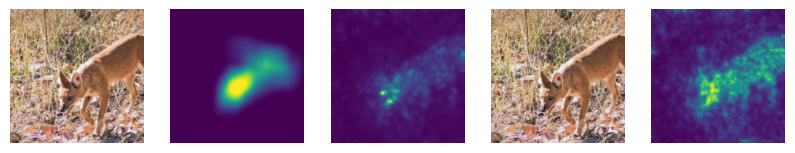

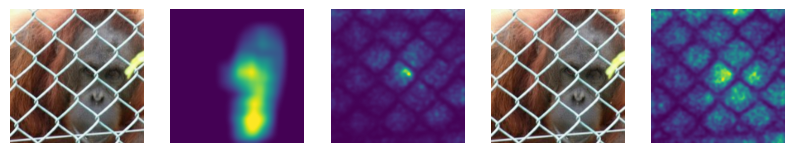

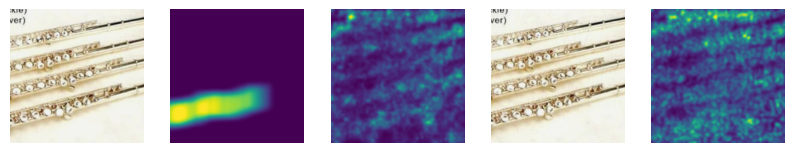

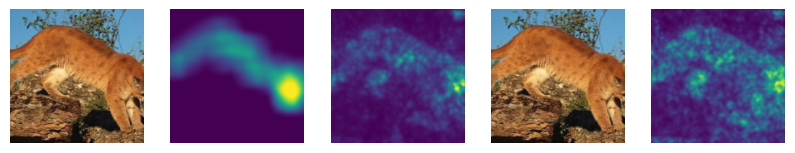

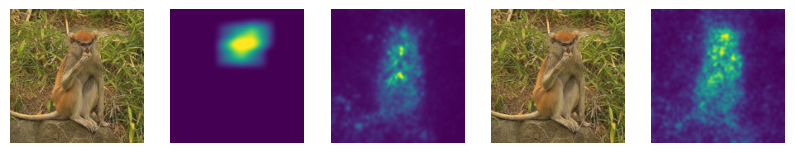

In [7]:
model_name = 'repvgg_b2.rvgg_in1k'
ori_model, transform_train, transform_eval, data_config = model_loader.load_timm_model(
    model_name, pretrained=configs.NEED_PRETRAINED, num_classes=configs.NUM_CLASSES, device=device)

wrapped_model = model_loader.CustomModelWrapper(ori_model, data_config=data_config, mapper=superclass2imagenet_mapper)
# wrapped_model = model_loader.CustomModelWrapper(ori_model, normalize=None, mapper=superclass2imagenet_mapper)
wrapped_model.eval()

wrapped_model = wrapped_model.to(device)

BIG12_val_dataset = dataset.ClickMe(
    BIG12_paths, model_name, imagenet2superclass_mapper=imagenet2superclass_mapper, need_normalize=False, is_training=False)
BIG12_val_dataloader = DataLoader(BIG12_val_dataset, batch_size=1, num_workers=2, pin_memory=False, shuffle=False)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# attack = torchattacks.APGD(wrapped_model, norm='L2', eps=30, steps=100, n_restarts=1, seed=0, loss='ce', eot_iter=1, rho=.75, verbose=False)
# attack = torchattacks.PGDL2(wrapped_model, eps=configs.EPS, alpha=configs.ALPHA, steps=configs.STEPS)
# attack = torchattacks.PGDL2(wrapped_model, eps=1, alpha=0.1, steps=100)
# attack = torchattacks.CW(wrapped_model, c=10, kappa=0, steps=10000, lr=0.001)

import foolbox as fb
# preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
preprocessing = dict(mean=[0, 0, 0], std=[1, 1, 1], axis=-3)
fb_model = fb.models.PyTorchModel(wrapped_model, bounds=(0, 1), preprocessing=preprocessing)
attack = fb.attacks.L2FMNAttack(steps=1000, max_stepsize=1, min_stepsize=1e-5, gamma=10)
print(attack)

cnt = 0
for img, hmp, label in BIG12_val_dataloader:
    img, label = img.to(device), label.to(device)
    img = (img - img.min()) / (img.max() - img.min())
    # adv_img = attack(img, label) # torch.Size([1, 3, 224, 224])
    adv_img, _, is_adv = attack(fb_model, img, label, epsilons=None)

    with torch.no_grad():
        logits = wrapped_model(adv_img)
        adv_label_pred = torch.argmax(logits, dim=-1)

        logits = wrapped_model(img)
        label_pred = torch.argmax(logits, dim=-1)
    
    adv_img, img, label = adv_img.detach().cpu(), img.detach().cpu(), label.detach().cpu()
    atk_mask = torch.abs(torch.amax(adv_img - img, axis=1, keepdims=True)) # torch.Size([1, 3, 224, 224])
#     print(atk_mask.shape, atk_mask.max(), atk_mask.min())

    # Compute the L2 norm
    l2_norm = torch.norm(adv_img - img).item()
    
    print(label.item(), superclass2imagenet_mapper[label.item()][0], ' | ', 
          label_pred.item(), superclass2imagenet_mapper[label_pred.item()][0], ' | ',
          adv_label_pred.item(), superclass2imagenet_mapper[adv_label_pred.item()][0],' | ',
          is_adv.detach().cpu().item(),' | ', l2_norm)
    
    saliency_map_right_class = utils.compute_saliency_map(wrapped_model, img, label)
    # saliency_map_wrong_class = utils.compute_saliency_map(wrapped_model, img, adv_label_pred)
    # adv_saliency_map_right_class = utils.compute_saliency_map(wrapped_model, adv_img, label_pred)
    # adv_saliency_map_wrong_class = utils.compute_saliency_map(wrapped_model, adv_img, adv_label_pred)

    fig, axs = plt.subplots(1, 5, figsize=(10, 2))  
    utils.show_images(img, ax=axs[0])   
    utils.show_images(hmp, alpha=1, p=1, smooth=2, ax=axs[1])
    utils.show_images(saliency_map_right_class, alpha=1, p=0, smooth=2, ax=axs[2])
    utils.show_images(adv_img, ax=axs[3]) 
    utils.show_images(atk_mask, alpha=1, p=1, smooth=2, ax=axs[4]) 
    # utils.show_images(saliency_map_wrong_class, alpha=1, p=0, smooth=2, ax=axs[5])
    # utils.show_images(adv_saliency_map_right_class, alpha=1, p=0, smooth=2, ax=axs[6])
    # utils.show_images(adv_saliency_map_wrong_class, alpha=1, p=0, smooth=2, ax=axs[7])

    cnt += 1
    if cnt >= 5:
        break
    
    '''
    0 animate  |  0 animate  |  1 in-animate  |  0.593031644821167
0 animate  |  0 animate  |  1 in-animate  |  0.3144034743309021
1 in-animate  |  1 in-animate  |  0 animate  |  0.5792026519775391
0 animate  |  0 animate  |  1 in-animate  |  0.4362553656101227
0 animate  |  0 animate  |  1 in-animate  |  0.5036280155181885
0 animate  |  0 animate  |  1 in-animate  |  0.3214772641658783
    '''

L2FMNAttack(steps=1000, max_stepsize=1, init_attack=None, min_stepsize=1e-05, binary_search_steps=10, gamma=10, p=2, dual=2)
0 animate  |  0 animate  |  1 in-animate  |  True  |  5.705692768096924
0 animate  |  0 animate  |  1 in-animate  |  True  |  6.659203052520752
1 in-animate  |  1 in-animate  |  0 animate  |  True  |  3.785722494125366
0 animate  |  0 animate  |  1 in-animate  |  True  |  3.6584248542785645
0 animate  |  0 animate  |  1 in-animate  |  True  |  4.364284038543701


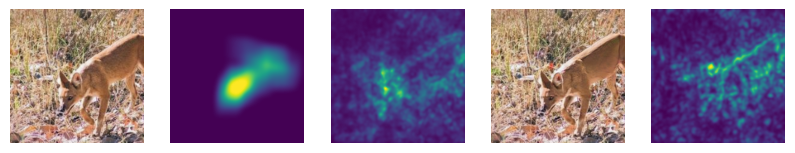

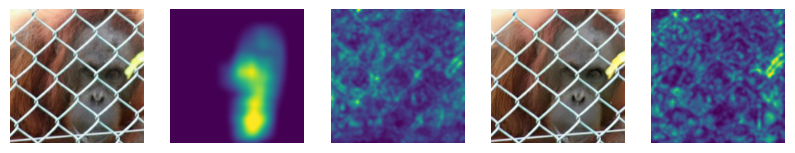

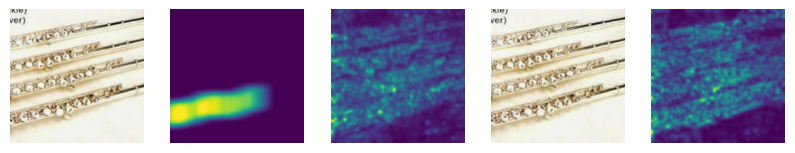

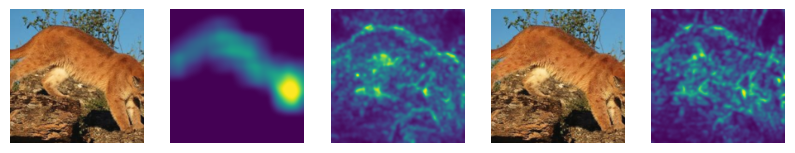

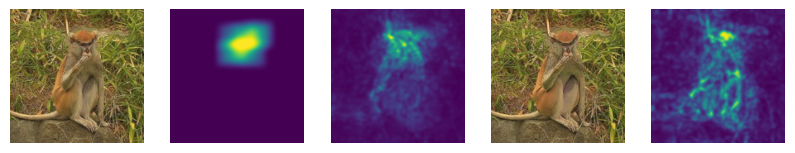

In [8]:
model_name = 'resnet18.tv_in1k'
ori_model, transform_train, transform_eval, data_config = model_loader.load_timm_model(
    model_name, pretrained=False, num_classes=configs.NUM_CLASSES, device=device)

from torchvision.models import resnet18
ckpt_path = os.path.join('/media/data_cifs/pfeng2/Adversarial_Alignment/models/resnet18_l2_eps1.ckpt')
ori_model = resnet18(pretrained=False)
checkpoint = torch.load(ckpt_path)
sd = {k[len('module.model.'):]:v for k,v in checkpoint['model'].items() if k[:len('module.model.')] == 'module.model.'}  # Consider only the model and not normalizers or attacker
ori_model.load_state_dict(sd)
ori_model = ori_model.to(device)
# ori_model = resnet18(pretrained=True)

# wrapped_model = model_loader.CustomModelWrapper(copy.deepcopy(ori_model), img_normalize, superclass2imagenet_mapper)
wrapped_model = model_loader.CustomModelWrapper(ori_model, data_config=data_config, mapper=superclass2imagenet_mapper)
wrapped_model.eval()

wrapped_model = wrapped_model.to(device)

BIG12_val_dataset = dataset.ClickMe(
    BIG12_paths, model_name, imagenet2superclass_mapper=imagenet2superclass_mapper, need_normalize=False, is_training=False)
BIG12_val_dataloader = DataLoader(BIG12_val_dataset, batch_size=1, num_workers=2, pin_memory=False, shuffle=False)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# attack = torchattacks.PGDL2(wrapped_model, eps=configs.EPS, alpha=configs.ALPHA, steps=configs.STEPS)
# attack = torchattacks.PGDL2(wrapped_model, eps=100, alpha=0.5, steps=1000)
# attack = torchattacks.CW(wrapped_model, c=10, kappa=0, steps=1000, lr=0.001)
# attack.normalization_used = None
# attack.set_mode_targeted_by_function(target_map_function=lambda images, labels:(labels+1)%9)

import foolbox as fb
# preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
preprocessing = dict(mean=[0, 0, 0], std=[1, 1, 1], axis=-3)
fb_model = fb.models.PyTorchModel(wrapped_model, bounds=(0, 1), preprocessing=preprocessing)
attack = fb.attacks.L2FMNAttack(steps=1000, max_stepsize=1, min_stepsize=1e-5, gamma=10)
print(attack)

cnt = 0
for img, hmp, label in BIG12_val_dataloader:
    # adv_img = attack(img, label) # torch.Size([1, 3, 224, 224])
    img, label = img.to(device), label.to(device)
    img = (img - img.min()) / (img.max() - img.min())
    adv_img, _, is_adv = attack(fb_model, img, label, epsilons=None)

    with torch.no_grad():
        logits = wrapped_model(adv_img)
        adv_label_pred = torch.argmax(logits, dim=-1)
        logits = wrapped_model(img)
        label_pred = torch.argmax(logits, dim=-1)

    adv_img, img, label = adv_img.detach().cpu(), img.detach().cpu(), label.detach().cpu()
    atk_mask = torch.abs(torch.amax(adv_img - img, axis=1, keepdims=True)) # torch.Size([1, 3, 224, 224])
#     print(atk_mask.shape, atk_mask.max(), atk_mask.min())

    # Compute the L2 norm
    l2_norm = torch.norm(adv_img - img).item()
    
    print(label.item(), superclass2imagenet_mapper[label.item()][0], ' | ', 
          label_pred.item(), superclass2imagenet_mapper[label_pred.item()][0], ' | ',
          adv_label_pred.item(), superclass2imagenet_mapper[adv_label_pred.item()][0],' | ',
          is_adv.detach().cpu().item(), ' | ', l2_norm)
    
    saliency_map_right_class = utils.compute_saliency_map(wrapped_model, img, label)
    # saliency_map_wrong_class = utils.compute_saliency_map(wrapped_model, img, adv_label_pred)
    # adv_saliency_map_right_class = utils.compute_saliency_map(wrapped_model, adv_img, label_pred)
    # adv_saliency_map_wrong_class = utils.compute_saliency_map(wrapped_model, adv_img, adv_label_pred)

    fig, axs = plt.subplots(1, 5, figsize=(10, 2))  
    utils.show_images(img, ax=axs[0])   
    utils.show_images(hmp, alpha=1, p=1, smooth=2, ax=axs[1])
    utils.show_images(saliency_map_right_class, alpha=1, p=0, smooth=2, ax=axs[2])
    utils.show_images(adv_img, ax=axs[3]) 
    utils.show_images(atk_mask, alpha=1, p=1, smooth=2, ax=axs[4]) 
    # utils.show_images(saliency_map_wrong_class, alpha=1, p=0, smooth=2, ax=axs[5])
    # utils.show_images(adv_saliency_map_right_class, alpha=1, p=0, smooth=2, ax=axs[6])
    # utils.show_images(adv_saliency_map_wrong_class, alpha=1, p=0, smooth=2, ax=axs[7])

    cnt += 1
    if cnt >= 5:
        break


L2FMNAttack(steps=1000, max_stepsize=1, init_attack=None, min_stepsize=1e-05, binary_search_steps=10, gamma=10, p=2, dual=2)
0 animate  |  0 animate  |  1 in-animate  |  True  |  13.374119758605957 Time = 33.08949613571167 secs
0 animate  |  0 animate  |  1 in-animate  |  True  |  10.647300720214844 Time = 32.51253652572632 secs
1 in-animate  |  1 in-animate  |  0 animate  |  True  |  13.229351997375488 Time = 32.460501194000244 secs
0 animate  |  0 animate  |  1 in-animate  |  True  |  8.482890129089355 Time = 32.803940534591675 secs
0 animate  |  0 animate  |  1 in-animate  |  True  |  10.097554206848145 Time = 32.57004690170288 secs


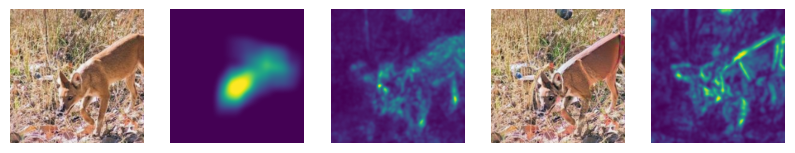

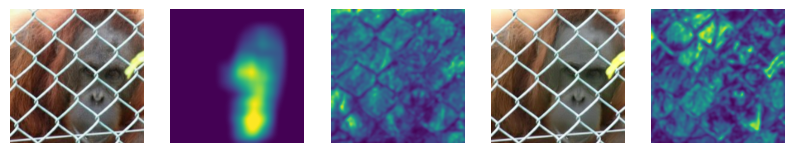

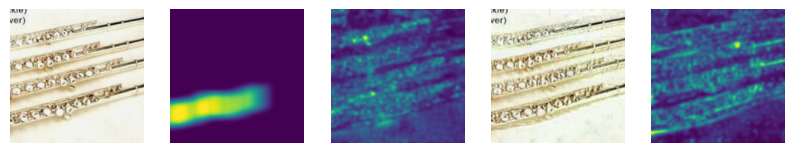

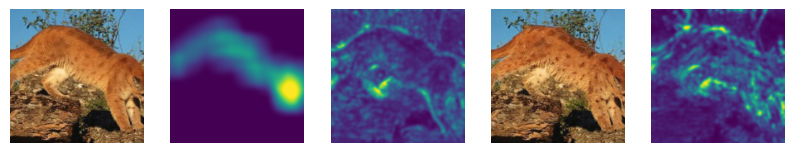

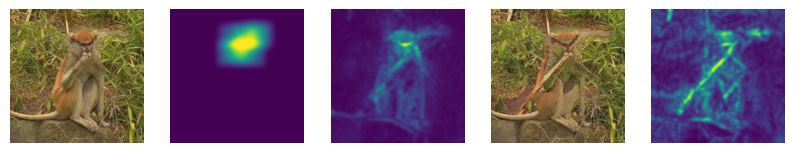

In [9]:
model_name = 'resnet50.tv_in1k'
ori_model, transform_train, transform_eval, data_config = model_loader.load_timm_model(
    model_name, pretrained=False, num_classes=configs.NUM_CLASSES, device=device)

from torchvision.models import wide_resnet50_2
ckpt_path = os.path.join('/media/data_cifs/pfeng2/Adversarial_Alignment/models/wide_resnet50_2_l2_eps5.ckpt')
ori_model = wide_resnet50_2(pretrained=False)
checkpoint = torch.load(ckpt_path)
sd = {k[len('module.model.'):]:v for k,v in checkpoint['model'].items() if k[:len('module.model.')] == 'module.model.'}  # Consider only the model and not normalizers or attacker
ori_model.load_state_dict(sd)
ori_model = ori_model.to(device)
# ori_model = resnet18(pretrained=True)

# wrapped_model = model_loader.CustomModelWrapper(copy.deepcopy(ori_model), img_normalize, superclass2imagenet_mapper)
wrapped_model = model_loader.CustomModelWrapper(ori_model, data_config=data_config, mapper=superclass2imagenet_mapper)
wrapped_model.eval()

wrapped_model = wrapped_model.to(device)

BIG12_val_dataset = dataset.ClickMe(
    BIG12_paths, model_name, imagenet2superclass_mapper=imagenet2superclass_mapper, need_normalize=False, is_training=False)
BIG12_val_dataloader = DataLoader(BIG12_val_dataset, batch_size=1, num_workers=2, pin_memory=False, shuffle=False)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# attack = torchattacks.PGDL2(wrapped_model, eps=configs.EPS, alpha=configs.ALPHA, steps=configs.STEPS)
# attack = torchattacks.PGDL2(wrapped_model, eps=100, alpha=0.5, steps=1000)
# attack = torchattacks.CW(wrapped_model, c=10, kappa=0, steps=1000, lr=0.001)
# attack.normalization_used = None
# attack.set_mode_targeted_by_function(target_map_function=lambda images, labels:(labels+1)%9)

import foolbox as fb
# preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
preprocessing = dict(mean=[0, 0, 0], std=[1, 1, 1], axis=-3)
fb_model = fb.models.PyTorchModel(wrapped_model, bounds=(0, 1), preprocessing=preprocessing)
attack = fb.attacks.L2FMNAttack(steps=1000, max_stepsize=1, min_stepsize=1e-5, gamma=10)
print(attack)

cnt = 0

for img, hmp, label in BIG12_val_dataloader:
    start = time.time()
    
    # adv_img = attack(img, label) # torch.Size([1, 3, 224, 224])
    img, label = img.to(device), label.to(device)
    img = (img - img.min()) / (img.max() - img.min())
    adv_img, _, is_adv = attack(fb_model, img, label, epsilons=None)

    with torch.no_grad():
        logits = wrapped_model(adv_img)
        adv_label_pred = torch.argmax(logits, dim=-1)
        logits = wrapped_model(img)
        label_pred = torch.argmax(logits, dim=-1)

    adv_img, img, label = adv_img.detach().cpu(), img.detach().cpu(), label.detach().cpu()
    atk_mask = torch.abs(torch.amax(adv_img - img, axis=1, keepdims=True)) # torch.Size([1, 3, 224, 224])
#     print(atk_mask.shape, atk_mask.max(), atk_mask.min())

    # Compute the L2 norm
    l2_norm = torch.norm(adv_img - img).item()

    end = time.time()
    print(label.item(), superclass2imagenet_mapper[label.item()][0], ' | ', 
          label_pred.item(), superclass2imagenet_mapper[label_pred.item()][0], ' | ',
          adv_label_pred.item(), superclass2imagenet_mapper[adv_label_pred.item()][0],' | ',
          is_adv.detach().cpu().item(), ' | ', l2_norm, f"Time = {end - start} secs")
    
    
    saliency_map_right_class = utils.compute_saliency_map(wrapped_model, img, label)
    # saliency_map_wrong_class = utils.compute_saliency_map(wrapped_model, img, adv_label_pred)
    # adv_saliency_map_right_class = utils.compute_saliency_map(wrapped_model, adv_img, label_pred)
    # adv_saliency_map_wrong_class = utils.compute_saliency_map(wrapped_model, adv_img, adv_label_pred)

    fig, axs = plt.subplots(1, 5, figsize=(10, 2))  
    utils.show_images(img, ax=axs[0])   
    utils.show_images(hmp, alpha=1, p=1, smooth=2, ax=axs[1])
    utils.show_images(saliency_map_right_class, alpha=1, p=0, smooth=2, ax=axs[2])
    utils.show_images(adv_img, ax=axs[3]) 
    utils.show_images(atk_mask, alpha=1, p=1, smooth=2, ax=axs[4]) 
    # utils.show_images(saliency_map_wrong_class, alpha=1, p=0, smooth=2, ax=axs[5])
    # utils.show_images(adv_saliency_map_right_class, alpha=1, p=0, smooth=2, ax=axs[6])
    # utils.show_images(adv_saliency_map_wrong_class, alpha=1, p=0, smooth=2, ax=axs[7])

    cnt += 1
    if cnt >= 5:
        break

L2FMNAttack(steps=1000, max_stepsize=1, init_attack=None, min_stepsize=1e-05, binary_search_steps=10, gamma=10, p=2, dual=2)
torch.Size([4, 3, 224, 224]) torch.Size([4, 3, 224, 224]) torch.Size([4])
torch.Size([4, 1, 224, 224]) tensor(0.3697) tensor(8.9407e-08)
0 animate  |  0 animate  |  1 in-animate  |  True  |  13.371838569641113
0 animate  |  0 animate  |  1 in-animate  |  True  |  10.64665412902832
1 in-animate  |  1 in-animate  |  0 animate  |  True  |  13.214045524597168
0 animate  |  0 animate  |  1 in-animate  |  True  |  8.481064796447754
Time=35.77165412902832


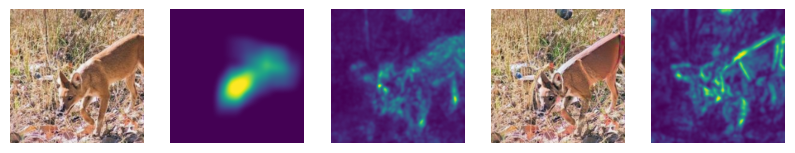

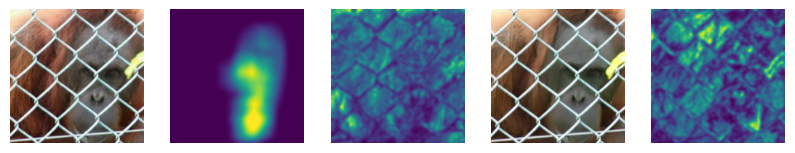

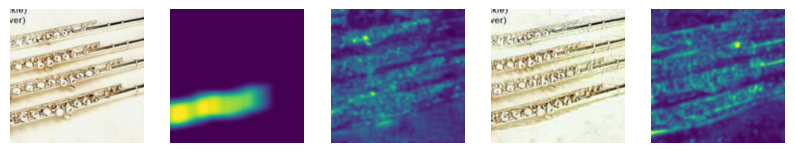

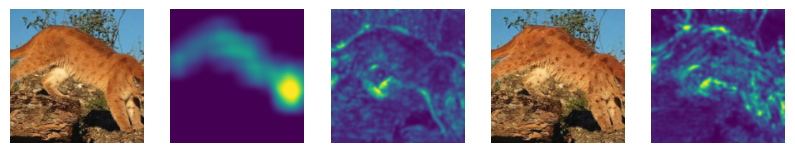

In [10]:
model_name = 'resnet50.tv_in1k'
ori_model, transform_train, transform_eval, data_config = model_loader.load_timm_model(
    model_name, pretrained=False, num_classes=configs.NUM_CLASSES, device=device)

from torchvision.models import wide_resnet50_2
ckpt_path = os.path.join('/media/data_cifs/pfeng2/Adversarial_Alignment/models/wide_resnet50_2_l2_eps5.ckpt')
ori_model = wide_resnet50_2(pretrained=False)
checkpoint = torch.load(ckpt_path)
sd = {k[len('module.model.'):]:v for k,v in checkpoint['model'].items() if k[:len('module.model.')] == 'module.model.'}  # Consider only the model and not normalizers or attacker
ori_model.load_state_dict(sd)
ori_model = ori_model.to(device)
# ori_model = resnet18(pretrained=True)

# wrapped_model = model_loader.CustomModelWrapper(copy.deepcopy(ori_model), img_normalize, superclass2imagenet_mapper)
wrapped_model = model_loader.CustomModelWrapper(ori_model, data_config=data_config, mapper=superclass2imagenet_mapper)
wrapped_model.eval()

wrapped_model = wrapped_model.to(device)

batch_size = 4
BIG12_val_dataset = dataset.ClickMe(
    BIG12_paths, model_name, imagenet2superclass_mapper=imagenet2superclass_mapper, need_normalize=False, is_training=False)
BIG12_val_dataloader = DataLoader(BIG12_val_dataset, batch_size=batch_size, num_workers=2, pin_memory=False, shuffle=False)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# attack = torchattacks.PGDL2(wrapped_model, eps=configs.EPS, alpha=configs.ALPHA, steps=configs.STEPS)
# attack = torchattacks.PGDL2(wrapped_model, eps=100, alpha=0.5, steps=1000)
# attack = torchattacks.CW(wrapped_model, c=10, kappa=0, steps=1000, lr=0.001)
# attack.normalization_used = None
# attack.set_mode_targeted_by_function(target_map_function=lambda images, labels:(labels+1)%9)

import foolbox as fb
# preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
preprocessing = dict(mean=[0, 0, 0], std=[1, 1, 1], axis=-3)
fb_model = fb.models.PyTorchModel(wrapped_model, bounds=(0, 1), preprocessing=preprocessing)
attack = fb.attacks.L2FMNAttack(steps=1000, max_stepsize=1, min_stepsize=1e-5, gamma=10)
print(attack)

cnt = 0

for imgs, hmps, labels in BIG12_val_dataloader:
    start = time.time()
    
    # adv_img = attack(img, label) # torch.Size([1, 3, 224, 224])
    imgs, labels = imgs.to(device), labels.to(device)
    imgs = (imgs - imgs.min()) / (imgs.max() - imgs.min())
    adv_imgs, _, is_advs = attack(fb_model, imgs, labels, epsilons=None)

    with torch.no_grad():
        logits = wrapped_model(adv_imgs)
        adv_label_preds = torch.argmax(logits, dim=-1)
        logits = wrapped_model(imgs)
        label_preds = torch.argmax(logits, dim=-1)

    adv_imgs, imgs, labels = adv_imgs.detach().cpu(), imgs.detach().cpu(), labels.detach().cpu()
    print(adv_imgs.shape, imgs.shape, labels.shape)
    atk_masks = torch.abs(torch.amax(adv_imgs - imgs, axis=1, keepdims=True)) # torch.Size([B, 1, 224, 224])
    print(atk_masks.shape, atk_masks.max(), atk_masks.min())

    # Compute the L2 norm
    l2_norms = torch.norm(adv_imgs - imgs, p=2, dim=(1, 2, 3)).tolist()

    for i in range(batch_size):
        print(labels[i].item(), superclass2imagenet_mapper[labels[i].item()][0], ' | ', 
              label_preds[i].item(), superclass2imagenet_mapper[label_preds[i].item()][0], ' | ',
              adv_label_preds[i].item(), superclass2imagenet_mapper[adv_label_preds[i].item()][0],' | ',
              is_advs[i].detach().cpu().item(), ' | ', l2_norms[i])
        
        
        saliency_map_right_class = utils.compute_saliency_map(wrapped_model, imgs[i][None, :], labels[i])
    
        fig, axs = plt.subplots(1, 5, figsize=(10, 2))  
        utils.show_images(imgs[i], ax=axs[0])   
        utils.show_images(hmps[i], alpha=1, p=1, smooth=2, ax=axs[1])
        utils.show_images(saliency_map_right_class, alpha=1, p=0, smooth=2, ax=axs[2])
        utils.show_images(adv_imgs[i], ax=axs[3]) 
        utils.show_images(atk_masks[i], alpha=1, p=1, smooth=2, ax=axs[4]) 

    end = time.time()
    print(f"Time={end-start}")

    cnt += 1
    if cnt >= 1:
        break

L2FMNAttack(steps=1000, max_stepsize=1, init_attack=None, min_stepsize=1e-05, binary_search_steps=10, gamma=10, p=2, dual=2)
torch.Size([4, 3, 224, 224]) torch.Size([4, 3, 224, 224]) torch.Size([4])
torch.Size([4, 1, 224, 224]) tensor(0.2191) tensor(2.9802e-08)
0 animate  |  0 animate  |  1 in-animate  |  True  |  2.3263611793518066
0 animate  |  0 animate  |  1 in-animate  |  True  |  2.6645493507385254
1 in-animate  |  1 in-animate  |  0 animate  |  True  |  2.8792757987976074
0 animate  |  0 animate  |  1 in-animate  |  True  |  1.918904423713684
Time=32.6053831577301


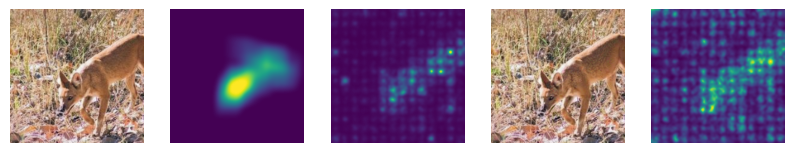

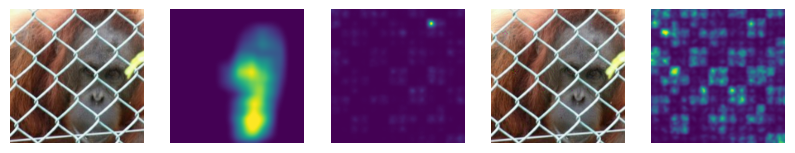

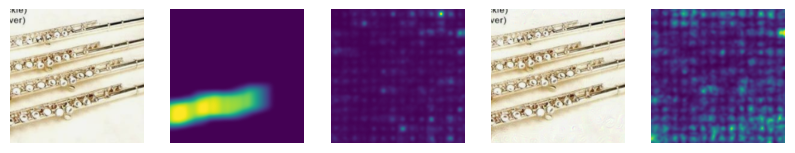

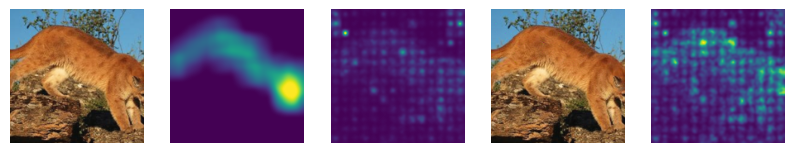

In [13]:
model_name = 'vit_small_patch16_224.augreg_in21k_ft_in1k'
ori_model, transform_train, transform_eval, data_config = model_loader.load_timm_model(
    model_name, pretrained=configs.NEED_PRETRAINED, num_classes=configs.NUM_CLASSES, device=device)

# wrapped_model = model_loader.CustomModelWrapper(copy.deepcopy(ori_model), img_normalize, superclass2imagenet_mapper)
wrapped_model = model_loader.CustomModelWrapper(ori_model, data_config=data_config, mapper=superclass2imagenet_mapper)
wrapped_model.eval()

wrapped_model = wrapped_model.to(device)

batch_size = 4
BIG12_val_dataset = dataset.ClickMe(
    BIG12_paths, model_name, imagenet2superclass_mapper=imagenet2superclass_mapper, need_normalize=False, is_training=False)
BIG12_val_dataloader = DataLoader(BIG12_val_dataset, batch_size=batch_size, num_workers=2, pin_memory=False, shuffle=False)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

import foolbox as fb
# preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
preprocessing = dict(mean=[0, 0, 0], std=[1, 1, 1], axis=-3)
fb_model = fb.models.PyTorchModel(wrapped_model, bounds=(0, 1), preprocessing=preprocessing)
attack = fb.attacks.L2FMNAttack(steps=1000, max_stepsize=1, min_stepsize=1e-5, gamma=10)
print(attack)

cnt = 0

for imgs, hmps, labels in BIG12_val_dataloader:
    start = time.time()
    
    # adv_img = attack(img, label) # torch.Size([1, 3, 224, 224])
    imgs, labels = imgs.to(device), labels.to(device)
    imgs = (imgs - imgs.min()) / (imgs.max() - imgs.min())
    adv_imgs, _, is_advs = attack(fb_model, imgs, labels, epsilons=None)

    with torch.no_grad():
        logits = wrapped_model(adv_imgs)
        adv_label_preds = torch.argmax(logits, dim=-1)
        logits = wrapped_model(imgs)
        label_preds = torch.argmax(logits, dim=-1)

    adv_imgs, imgs, labels = adv_imgs.detach().cpu(), imgs.detach().cpu(), labels.detach().cpu()
    print(adv_imgs.shape, imgs.shape, labels.shape)
    atk_masks = torch.abs(torch.amax(adv_imgs - imgs, axis=1, keepdims=True)) # torch.Size([B, 1, 224, 224])
    print(atk_masks.shape, atk_masks.max(), atk_masks.min())

    # Compute the L2 norm
    l2_norms = torch.norm(adv_imgs - imgs, p=2, dim=(1, 2, 3)).tolist()

    for i in range(batch_size):
        print(labels[i].item(), superclass2imagenet_mapper[labels[i].item()][0], ' | ', 
              label_preds[i].item(), superclass2imagenet_mapper[label_preds[i].item()][0], ' | ',
              adv_label_preds[i].item(), superclass2imagenet_mapper[adv_label_preds[i].item()][0],' | ',
              is_advs[i].detach().cpu().item(), ' | ', l2_norms[i])
        
        
        saliency_map_right_class = utils.compute_saliency_map(wrapped_model, imgs[i][None, :], labels[i])
    
        fig, axs = plt.subplots(1, 5, figsize=(10, 2))  
        utils.show_images(imgs[i], ax=axs[0])   
        utils.show_images(hmps[i], alpha=1, p=1, smooth=2, ax=axs[1])
        utils.show_images(saliency_map_right_class, alpha=1, p=0, smooth=2, ax=axs[2])
        utils.show_images(adv_imgs[i], ax=axs[3]) 
        utils.show_images(atk_masks[i], alpha=1, p=1, smooth=2, ax=axs[4]) 

    end = time.time()
    print(f"Time={end-start}")

    cnt += 1
    if cnt >= 1:
        break